In [1]:
import http.cookiejar as cookielib
import pandas as pd
import requests
import warnings
import logging
import sqlite3
import boto3
import glob
import json
import time
import math
import tqdm
import sys
import os

sys.path.append("/opt/libs")
from apiclass import APIClass,RedshiftClass
from apikeyclass import APIkeyClass
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

from sc_experiments import *
from constants_and_utils import *
from time_series import *
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats.stats import pearsonr

warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

Successful connection！
 
Successful connection！
 


## Battery-BMS Time Series Analysis

### Setup

In [2]:
# load BOM dictionary
bom = parse_battery_bom()
bom =  {k.lower(): v for k, v in bom.items()}
print('num parts', len(bom))
print('BMS codes', bom['bms'])

num parts 16
BMS codes ['850450', '850730', '850780', '850790', '853222', '853223', '853321', '853340', '853630', '853641', '853890', '854190', '854239', '854290', '854411', '854442', '854449']


In [3]:
# What are specific suppliers we should analyze?
# load index: top 200 supplier of battery in terms of bill count 
query = f"select supplier_t, SUM(bill_count) AS battery_sum from index_hs6 WHERE hs6 LIKE '850760%' AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count) DESC;"
battery_index = rs.query_df(query)
display(battery_index)

,supplier_t,battery_sum
0,sevt,21289
1,dell global b.v,6061
2,sdiv,5971
3,amperex technology limited,4428
4,wistron corporation,3845
...,...,...
4490,hitachi vantara llc,1
4491,merlin distributor inc,1
4492,"unifortune hk company.,ltd",1
4493,palm garden enterprises corp,1


In [4]:
# What are specific suppliers we should analyze?
# load index: top 200 supplier of battery in terms of bill count 
bms_codes_str = ""
for code in bom['bms']:
    bms_codes_str += f"{code}|"
bms_codes_str = f"'({bms_codes_str[:-1]})%'"
print(bms_codes_str)

bms_query = f"select supplier_t, SUM(bill_count) AS bms_sum from index_hs6 WHERE hs6 SIMILAR TO {bms_codes_str} AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count) DESC;"
#bms_query = f"select supplier_t, SUM(bill_count) from index_hs6 WHERE hs6 IN {bms_codes_str} AND bill_count IS NOT NULL GROUP BY supplier_t ORDER BY SUM(bill_count);"
bms_index = rs.query_df(bms_query)
# index.supplier_t.to_csv("company_names_parse.csv", sep=',')
display(bms_index)

'(850450|850730|850780|850790|853222|853223|853321|853340|853630|853641|853890|854190|854239|854290|854411|854442|854449)%'


,supplier_t,bms_sum
0,te connectivity solutions gmbh,2350361
1,ultra charm limited,139589
2,lg electronics inc,112440
3,cong ty tnhh dien tu samsung hcmc ce complex,87794
4,tyco electronics middle east fze,69768
...,...,...
4435,cong ty tnhh misumi viet nam -chi nhanh tphcm,1
4436,albrecht baeumer gmbh co. kg,1
4437,"d&j int'l trading co.,ltd",1
4438,cong ty tnhh dich vu trane viet nam,1


In [5]:
index = pd.merge(battery_index, bms_index,  how='inner', on=['supplier_t'])
index = index[(index['battery_sum'] > 100) & (index['bms_sum'] > 100)]
index.to_csv("company_names_parse.csv", sep=',')
display(index)

,supplier_t,battery_sum,bms_sum
0,sevt,21289,15003
2,sdiv,5971,127
3,wistron corporation,3845,14815
4,hp international sarl,2298,3757
5,"samsung sdi co., ltd",1706,145
6,"elentec vietnam energy co.,ltd",1509,195
7,cong ty tnhh samsung sdi viet nam,1193,128
8,"itm semiconductor vietnam co., ltd",1013,9046
9,sehc,689,15454
10,"samsung electronics vietnam thai nguyen co.,ltd",658,553


In [ ]:
# # get companies that sell battery and buy BMS
# battery_suppliers = index[index.hs6 == BATTERY].groupby('supplier_t')['bill_count'].sum().rename('battery_supply_count')
# bms_buyers = index[index.hs6.isin(bom['bms'])].groupby('buyer_t')['bill_count'].sum().rename('bms_buy_count')
# merged = pd.merge(battery_suppliers, bms_buyers, left_index=True, right_index=True, how='inner')  # must have both
# display(merged.sort_values('battery_supply_count', ascending=False).head(30))
# display(merged.sort_values('bms_buy_count', ascending=False).head(30)) # TODO: panasonic, chinese companies

### Get Data

In [13]:
from time_series import *

In [7]:
# Get data for samsung
companies = dict_regex['samsung']
SUPPLY_PROD='battery'
BUY_PROD='bms'

In [8]:
csv_name = get_transaction_df(PROD=SUPPLY_PROD, tx_type='supplier', companies=companies)

850760 -> 1061963 1061963


In [9]:
csv_name = get_transaction_df(PROD=BUY_PROD, tx_type='buyer', companies=companies)

850450 -> 1712629 1712629
850730 -> 1658685 1658685
850780 -> 1658719 1658719
850790 -> 1660871 1660871
853222 -> 1659481 1659481
853223 -> 1658702 1658702
853321 -> 1721474 1721474
853340 -> 1662319 1662319
853630 -> 1659552 1659552
853641 -> 1658996 1658996
853890 -> 1659617 1659617
854190 -> 1658686 1658686
854239 -> 1730300 1730300
854290 -> 1658760 1658760
854411 -> 1659047 1659047
854442 -> 1699320 1699320
854449 -> 1667763 1667763


In [21]:
company_regex = ['wistron', 'hp', 'elentec', 'itm', 'verdant', 'luxshare', 'apple', 
                 'wingtech', 'lg', 'techtronic', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 
                 'tcl', 'hansol', 'buckeye', 'compal', 'truper']
SUPPLY_PROD='battery'
BUY_PROD='bms'
for regex in company_regex:
    companies = dict_regex[regex]
    csv_name = get_transaction_df(PROD=SUPPLY_PROD, tx_type='supplier', companies=companies)
    csv_name = get_transaction_df(PROD=BUY_PROD, tx_type='buyer', companies=companies)

850760 -> 3848 3848
850450 -> 76 76
850730 -> None
850780 -> None
850790 -> None
853222 -> 11 11
853223 -> None
853321 -> 75 75
853340 -> 5 5
853630 -> None
853641 -> None
853890 -> None
854190 -> None
854239 -> 386 386
854290 -> None
854411 -> None
854442 -> 164 164
854449 -> 53 53
850760 -> 4628 4628
850450 -> None
850730 -> None
850780 -> 2 2
850790 -> None
853222 -> None
853223 -> None
853321 -> None
853340 -> 2 2
853630 -> None
853641 -> 7 7
853890 -> 7 7
854190 -> None
854239 -> 82 82
854290 -> None
854411 -> None
854442 -> 14042 14042
854449 -> 1405 1405
850760 -> 1996 1996
850450 -> 63 63
850730 -> None
850780 -> None
850790 -> 274 274
853222 -> None
853223 -> None
853321 -> 255 255
853340 -> 73 73
853630 -> None
853641 -> 4 4
853890 -> None
854190 -> 245 245
854239 -> 307 307
854290 -> None
854411 -> None
854442 -> 97 97
854449 -> 1 1
850760 -> 1513 1513
850450 -> 16 16
850730 -> None
850780 -> 3 3
850790 -> 59 59
853222 -> None
853223 -> None
853321 -> None
853340 -> 408 408


### Statistical Analysis
1. Companies that purchases BMS and sells battery
2. Signs of propagation? What time scale? Go into their transactions, plot out quarter by quarter, aggregated BMS, battery.
3. Correlation (Pearson)
    a. BMS, Battery time series
    b. Global parameter needed? across companies

Successful connection！
 
Supply name is battery; buy name is bms
1061963 28444921


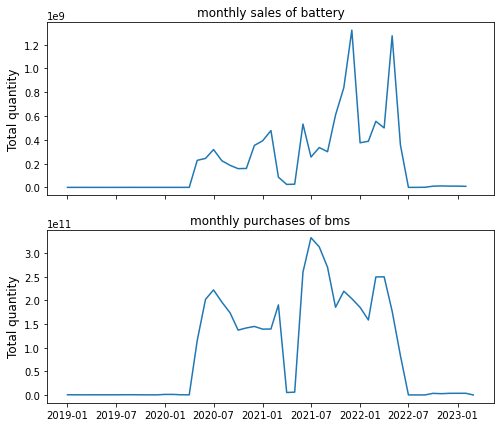

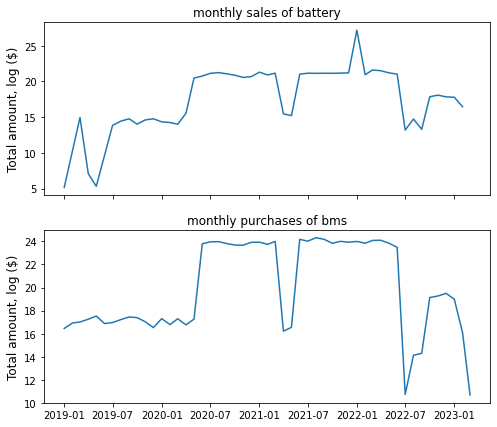

850450 608790 r=0.853 (n=48, p=0.000)
850730 17
850780 918 r=-0.239 (n=30, p=0.203)
850790 44584 r=0.827 (n=35, p=0.000)
853222 47393 r=0.534 (n=39, p=0.000)
853223 14960 r=0.337 (n=29, p=0.073)
853321 1023221 r=0.813 (n=46, p=0.000)
853340 97984 r=0.710 (n=47, p=0.000)
853630 8568 r=0.580 (n=45, p=0.000)
853641 7264 r=0.646 (n=44, p=0.000)
853890 18782 r=0.550 (n=38, p=0.000)
854190 1
854239 1111539 r=0.885 (n=48, p=0.000)
854290 6535 r=0.189 (n=28, p=0.336)
854411 5037 r=0.287 (n=35, p=0.095)
854442 691140 r=0.861 (n=48, p=0.000)
854449 569687 r=0.732 (n=45, p=0.000)


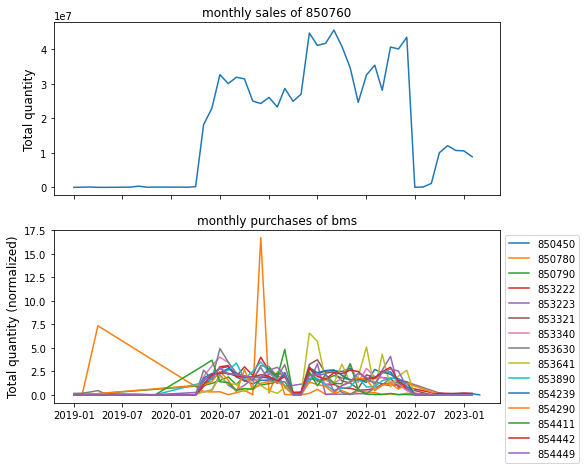

In [10]:
csv_name = 'samsung'
SUPPLY_PROD = 'battery'
BUY_PROD = 'bms'

supply_df, buy_df = get_transaction_time_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
summary_df = compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly", csv_name=csv_name)
summary_df = pd.DataFrame(summary_df, index=[0])
summary_df.to_csv(f"./summary/{csv_name}_summary.csv", sep=',')


Supply name is battery; buy name is bms
battery wistron
3848 770


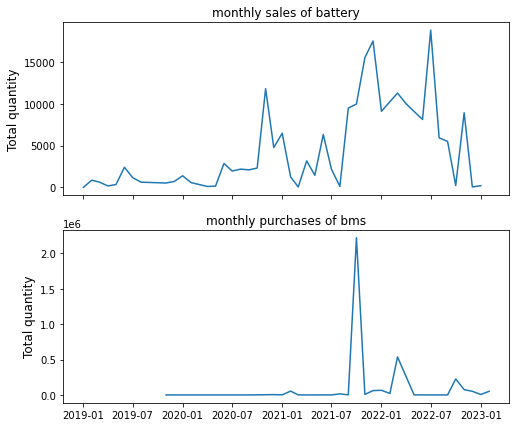

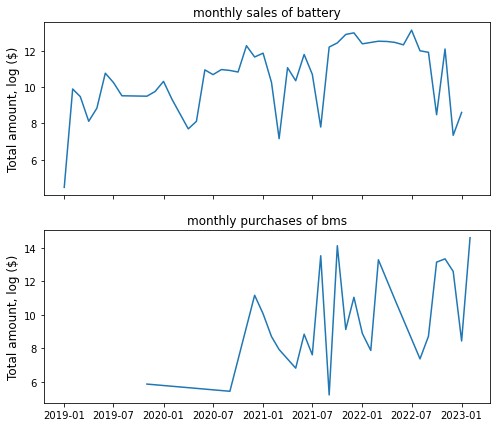

850450 76
850730 0
850780 0
850790 0
853222 11
853223 0
853321 75
853340 5
853630 0
853641 0
853890 0
854190 0
854239 386 r=0.251 (n=14, p=0.386)
854290 0
854411 0
854442 164 r=0.705 (n=16, p=0.002)
854449 53


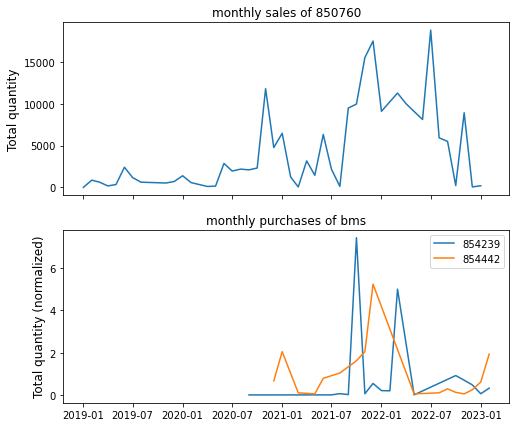

Supply name is battery; buy name is bms
battery hp
4628 15547


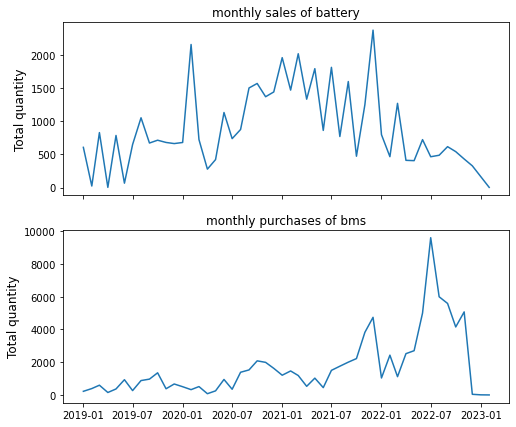

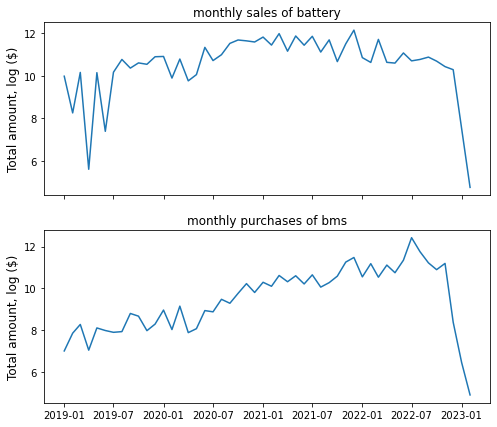

850450 0
850730 0
850780 2
850790 0
853222 0
853223 0
853321 0
853340 2
853630 0
853641 7
853890 7
854190 0
854239 82
854290 0
854411 0
854442 14042 r=0.005 (n=49, p=0.971)
854449 1405 r=-0.095 (n=47, p=0.524)


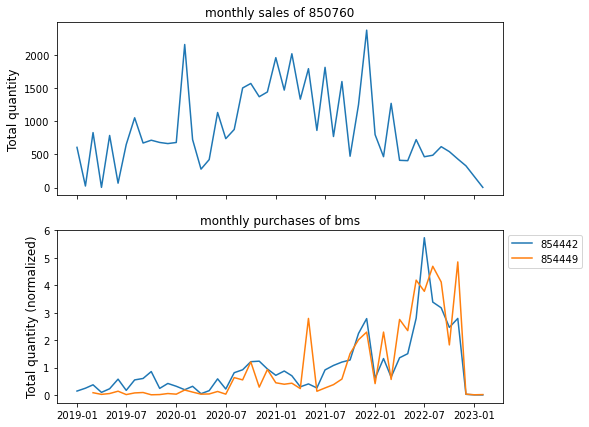

Supply name is battery; buy name is bms
battery elentec
1996 1319


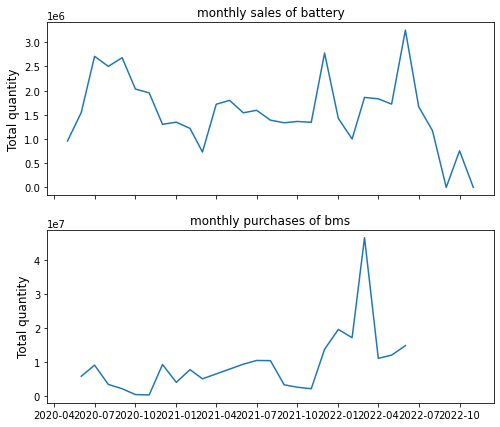

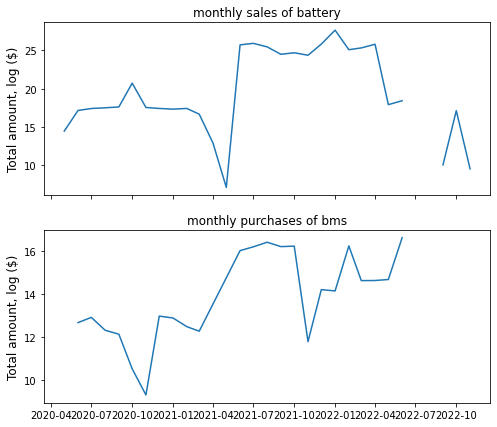

850450 63
850730 0
850780 0
850790 274 r=-0.135 (n=19, p=0.581)
853222 0
853223 0
853321 255 r=-0.060 (n=20, p=0.802)
853340 73
853630 0
853641 4
853890 0
854190 245 r=0.125 (n=23, p=0.569)
854239 307 r=0.196 (n=22, p=0.382)
854290 0
854411 0
854442 97
854449 1


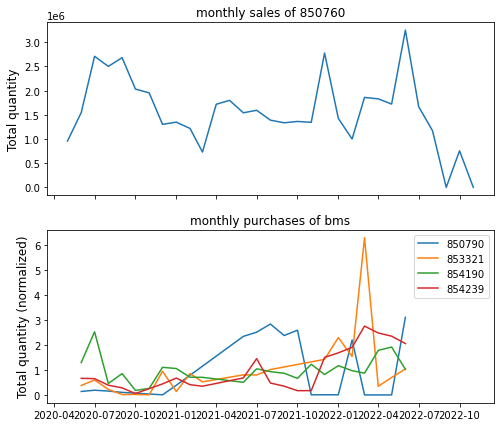

Supply name is battery; buy name is bms
battery itm
1513 17164


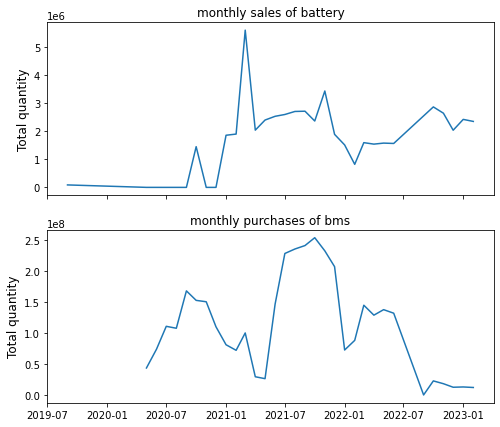

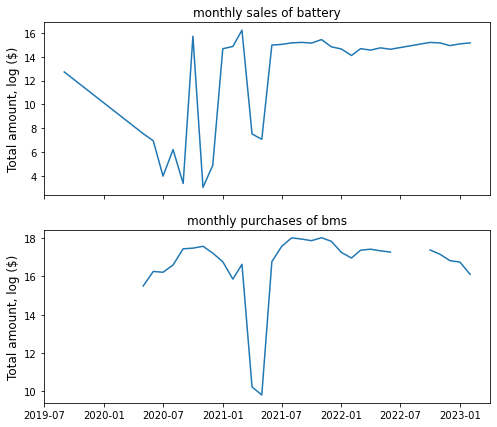

850450 16
850730 0
850780 3
850790 59
853222 0
853223 0
853321 0
853340 408 r=0.271 (n=26, p=0.180)
853630 135 r=0.597 (n=26, p=0.001)
853641 53
853890 148 r=0.349 (n=21, p=0.121)
854190 38
854239 8726 r=0.044 (n=31, p=0.814)
854290 6457 r=0.348 (n=31, p=0.055)
854411 18
854442 375 r=0.544 (n=24, p=0.006)
854449 728 r=-0.046 (n=27, p=0.821)


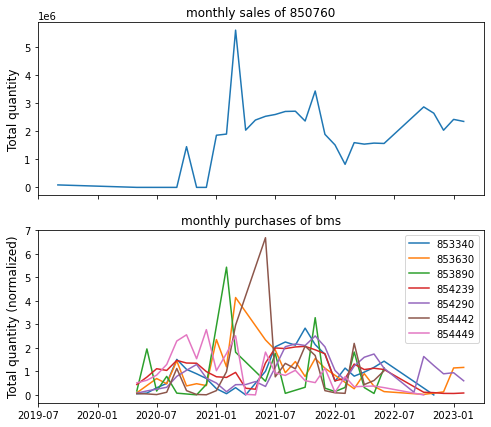

Supply name is battery; buy name is bms
battery luxshare
53580 1651492


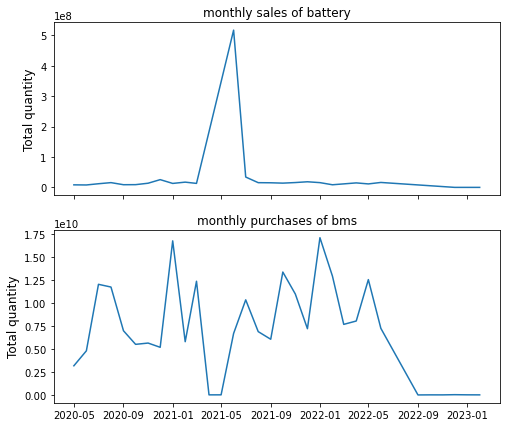

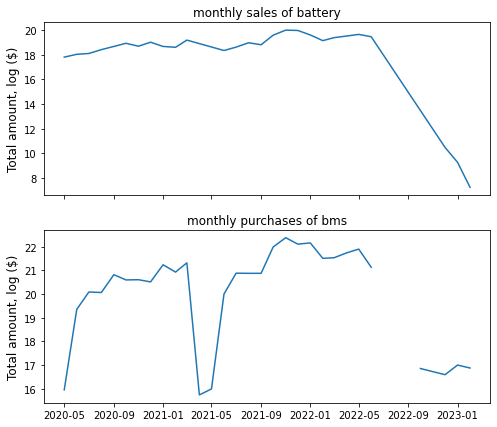

850450 51828 r=0.259 (n=26, p=0.201)
850730 0
850780 0
850790 0
853222 12717 r=-0.529 (n=23, p=0.009)
853223 7718 r=-0.324 (n=24, p=0.123)
853321 83416 r=0.333 (n=27, p=0.090)
853340 4
853630 0
853641 170 r=0.548 (n=5, p=0.339)
853890 22534 r=-0.385 (n=24, p=0.063)
854190 0
854239 96594 r=0.351 (n=27, p=0.073)
854290 10
854411 170 r=0.054 (n=5, p=0.932)
854442 29461 r=0.183 (n=27, p=0.362)
854449 45911 r=-0.348 (n=24, p=0.096)


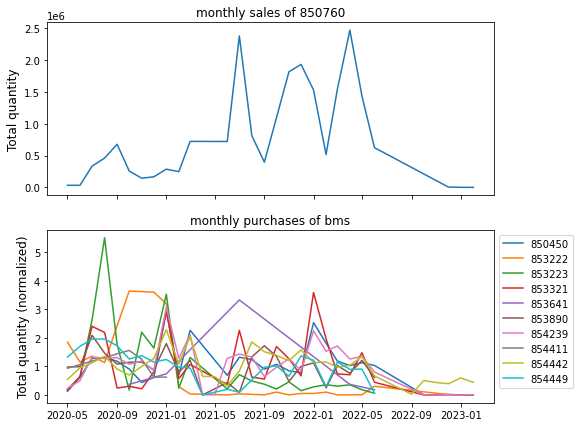

Supply name is battery; buy name is bms
battery apple
887 4925


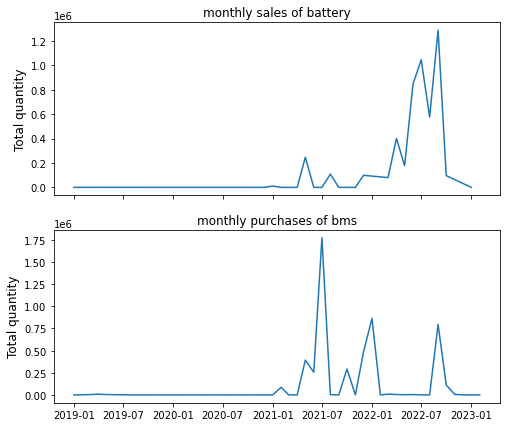

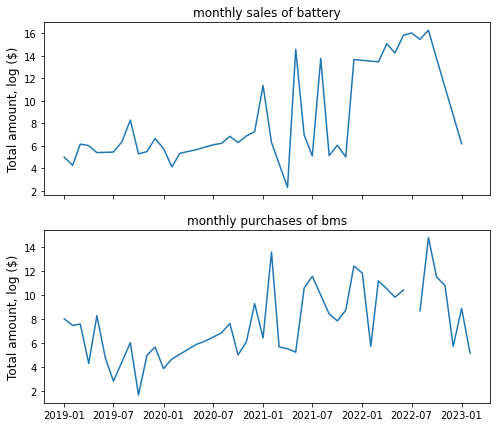

850450 9
850730 0
850780 0
850790 0
853222 1
853223 0
853321 32
853340 0
853630 0
853641 0
853890 12
854190 0
854239 57
854290 0
854411 0
854442 4812 r=0.631 (n=39, p=0.000)
854449 2


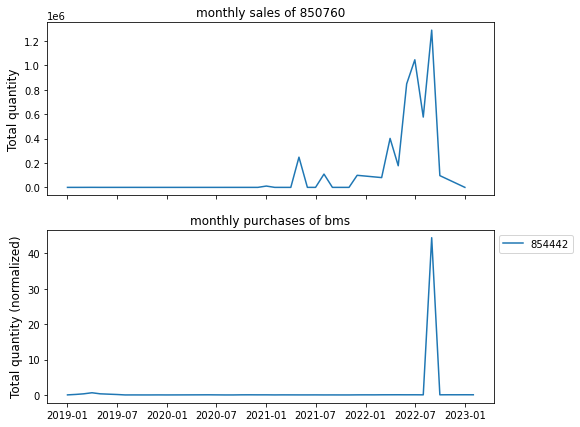

Supply name is battery; buy name is bms
battery lg
119297 8144148


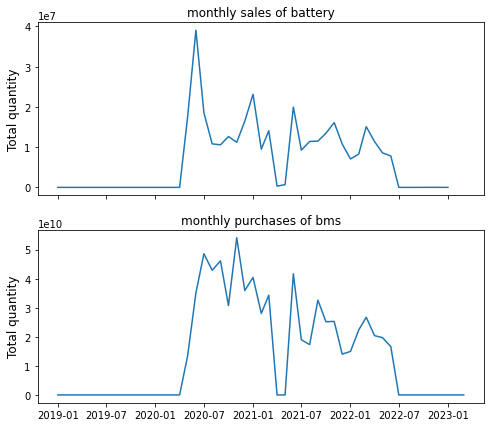

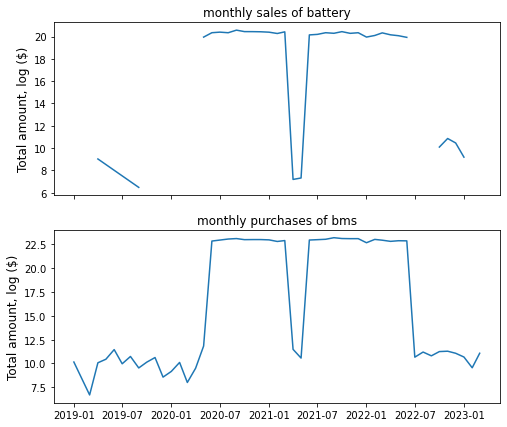

850450 644878 r=0.234 (n=29, p=0.222)
850730 17
850780 13
850790 20
853222 52016 r=0.201 (n=24, p=0.346)
853223 179 r=1.000 (n=2, p=1.000)
853321 936567 r=0.522 (n=27, p=0.005)
853340 51821 r=-0.236 (n=25, p=0.255)
853630 2
853641 1584 r=0.019 (n=22, p=0.932)
853890 1397 r=0.210 (n=24, p=0.325)
854190 0
854239 66310 r=0.708 (n=37, p=0.000)
854290 34
854411 238 r=-0.612 (n=7, p=0.144)
854442 124686 r=0.695 (n=33, p=0.000)
854449 940 r=-0.202 (n=21, p=0.381)


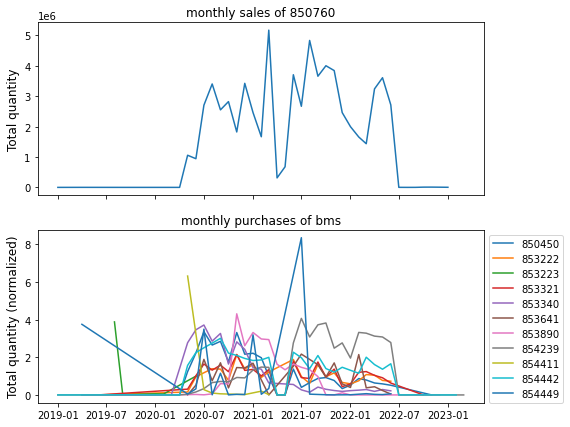

Supply name is battery; buy name is bms
battery techtronic
55188 2526247


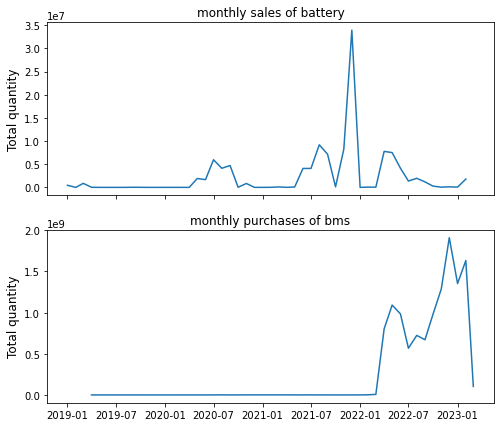

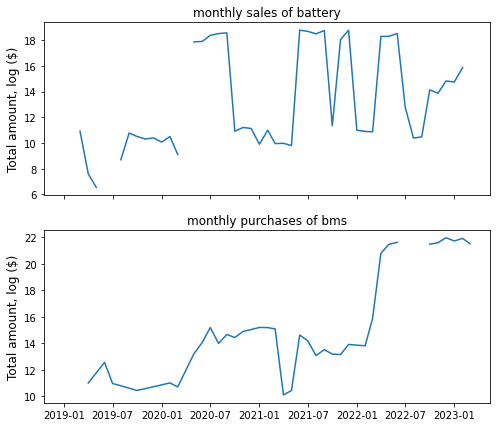

850450 35
850730 0
850780 0
850790 0
853222 1
853223 0
853321 0
853340 0
853630 0
853641 0
853890 37
854190 0
854239 2062 r=-0.041 (n=18, p=0.871)
854290 0
854411 651 r=-0.044 (n=14, p=0.881)
854442 8370 r=0.534 (n=18, p=0.023)
854449 2746 r=0.967 (n=15, p=0.000)


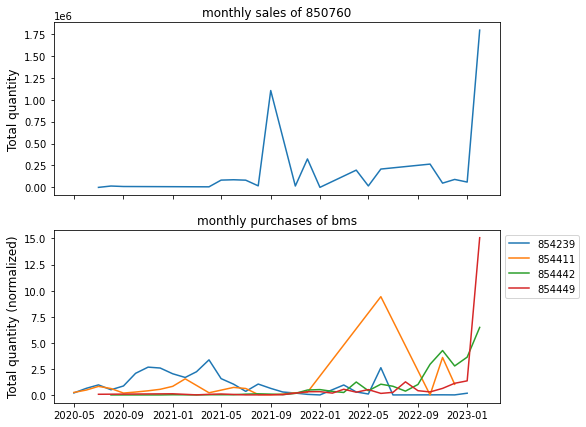

Supply name is battery; buy name is bms
battery compal
244 9009


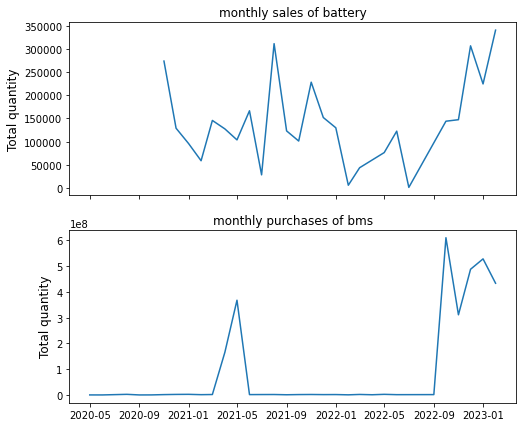

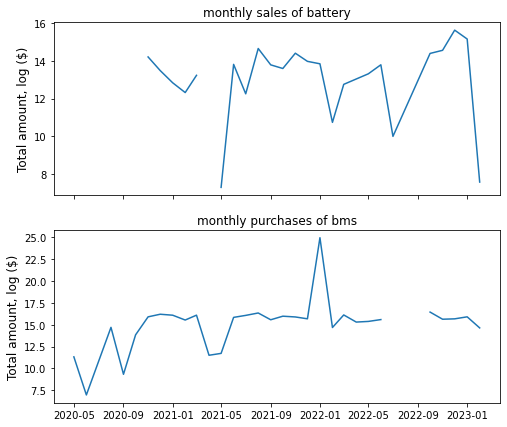

850450 2349 r=0.730 (n=11, p=0.011)
850730 0
850780 0
850790 0
853222 15
853223 0
853321 4249 r=0.544 (n=11, p=0.084)
853340 6
853630 0
853641 11
853890 0
854190 0
854239 1632 r=-0.132 (n=24, p=0.540)
854290 1
854411 6
854442 659 r=0.570 (n=21, p=0.007)
854449 81


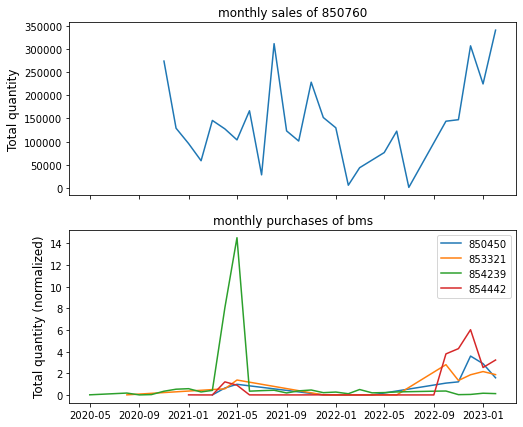

Supply name is battery; buy name is bms
battery truper
228 1372


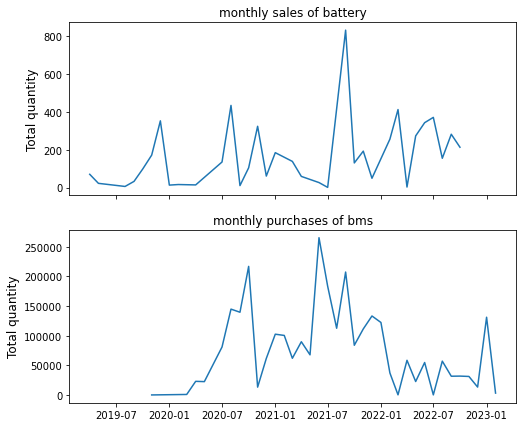

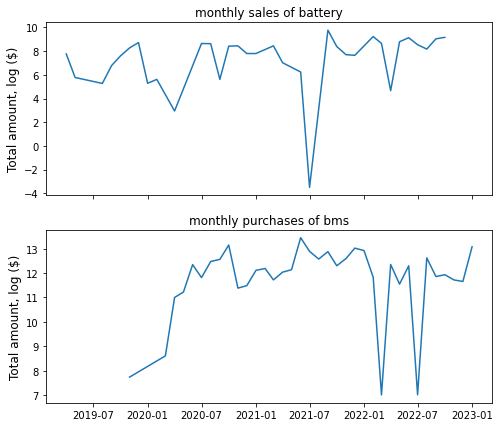

850450 3
850730 1
850780 1
850790 0
853222 0
853223 113 r=0.339 (n=15, p=0.217)
853321 0
853340 13
853630 5
853641 3
853890 105 r=-0.008 (n=17, p=0.975)
854190 0
854239 10
854290 0
854411 0
854442 960 r=-0.065 (n=25, p=0.759)
854449 158 r=0.047 (n=20, p=0.844)


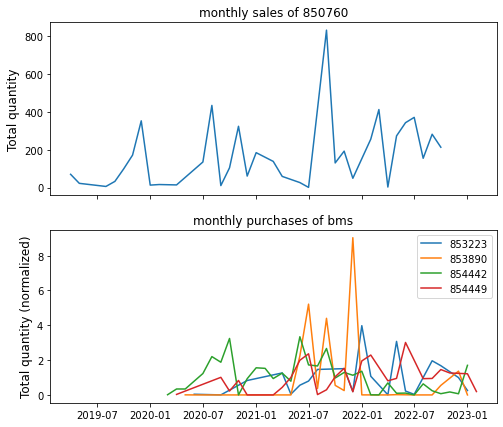

In [35]:
# 'verdant', 'wingtech', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 'tcl', 'hansol', 'buckeye',
companies = ['wistron', 'hp', 'elentec', 'itm', 'luxshare', 
             'apple', 'lg', 'techtronic', 'compal', 'truper']
SUPPLY_PROD='battery'
BUY_PROD='bms'

for csv_name in companies:
    supply_df, buy_df = get_transaction_time_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly", csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])

    summary_df.to_csv(f"./summary/{csv_name}_summary.csv", sep=',')
    del supply_df, buy_df
    
# TODO: concatenate and save summary_dfs

## Battery-Baseline Time Series Analysis

### Discover baseline options

In [ ]:
warnings.filterwarnings('ignore')
rs = RedshiftClass('zhiyin','Zhiyin123')

# load index: top 100 supplier in terms of bill_count
query = f"select hs6, SUM(bill_count) from index_hs6 WHERE bill_count IS NOT NULL GROUP BY hs6 ORDER BY SUM(bill_count) DESC LIMIT 100;"
index = rs.query_df(query)

# load hs_category_description table
query = f"select * from hs_category_description"
hs_index = rs.query_df(query)

# Merge index and hs_category_description table
display(index.merge(hs_index, how='left', on='hs6').head(50))

# 853710, 830242
# Very promising: 630790, 848120, 490199
# Alternative: bms percetile among all products in terms of r-value

In [36]:
BASELINE_PROD = ('853710', '830242', '630790', '848120', '490199',)

### Get Data (Baseline-Only)

In [37]:
companies = dict_regex["samsung"]
csv_name = get_transaction_df(PROD=BASELINE_PROD, tx_type='buyer', companies=companies)

853710 -> 1684765 1684765
830242 -> 1658772 1658772
630790 -> 1659645 1659645
848120 -> 1660722 1660722
490199 -> 1742083 1742083


In [38]:
company_regex = ['wistron', 'hp', 'elentec', 'itm', 'verdant', 'luxshare', 'apple', 
                 'wingtech', 'lg', 'techtronic', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 
                 'tcl', 'hansol', 'buckeye', 'compal', 'truper']
for regex in company_regex:
    companies = dict_regex[regex]
    csv_name = get_transaction_df(PROD=BASELINE_PROD, tx_type='buyer', companies=companies)

853710 -> None
830242 -> None
630790 -> None
848120 -> None
490199 -> None
853710 -> 472 472
830242 -> None
630790 -> 28 28
848120 -> 2 2
490199 -> 1 1
853710 -> 34 34
830242 -> None
630790 -> None
848120 -> None
490199 -> 1 1
853710 -> 325 325
830242 -> 36 36
630790 -> 64 64
848120 -> 118 118
490199 -> None
853710 -> None
830242 -> None
630790 -> None
848120 -> None
490199 -> None
853710 -> 96353 96353
830242 -> 96326 96326
630790 -> 96334 96334
848120 -> 96328 96328
490199 -> 96326 96326
853710 -> 32 32
830242 -> None
630790 -> 13 13
848120 -> None
490199 -> 11 11
853710 -> None
830242 -> None
630790 -> None
848120 -> None
490199 -> None
853710 -> 486820 486820
830242 -> 478914 478914
630790 -> 478914 478914
848120 -> 478914 478914
490199 -> 478918 478918
853710 -> 153843 153843
830242 -> 148472 148472
630790 -> 148530 148530
848120 -> 148472 148472
490199 -> 149278 149278
853710 -> None
830242 -> None
630790 -> None
848120 -> None
490199 -> None
853710 -> None
830242 -> None
630790 

### Statistical Analysis

Supply name is battery; buy name is baseline
battery hp
4628 503


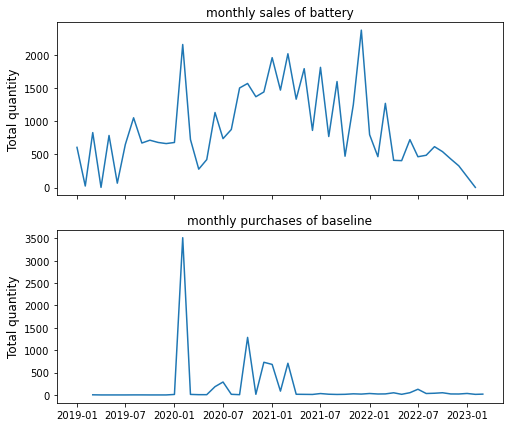

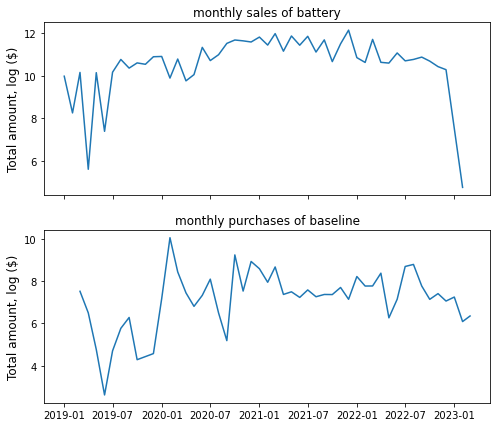

853710 472 r=-0.059 (n=46, p=0.697)
830242 0
630790 28
848120 2
490199 1


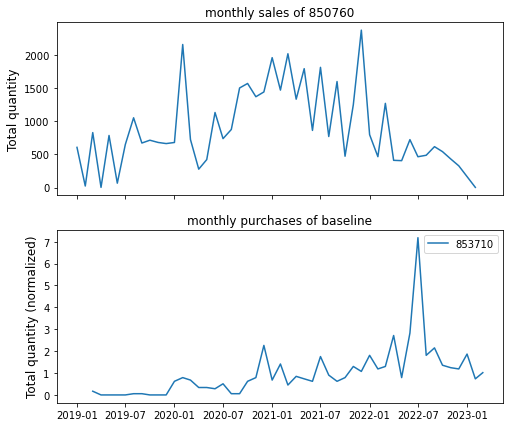

Supply name is battery; buy name is baseline
battery elentec
1996 35


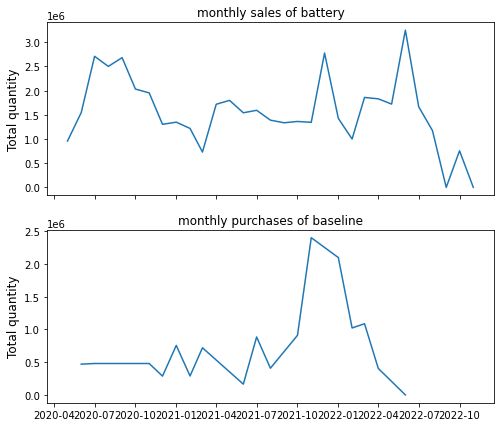

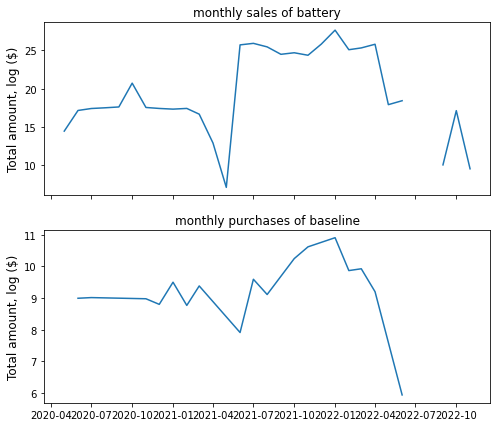

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


853710 34
830242 0
630790 0
848120 0
490199 1


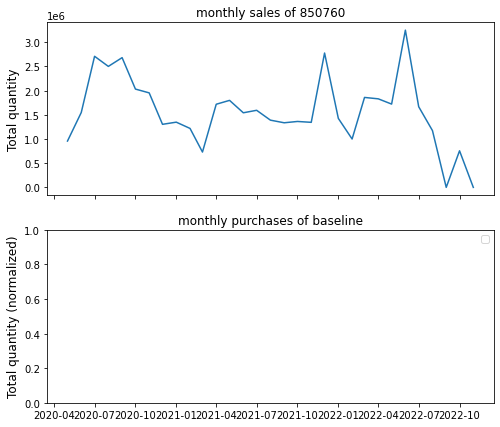

Supply name is battery; buy name is baseline
battery itm
1513 543


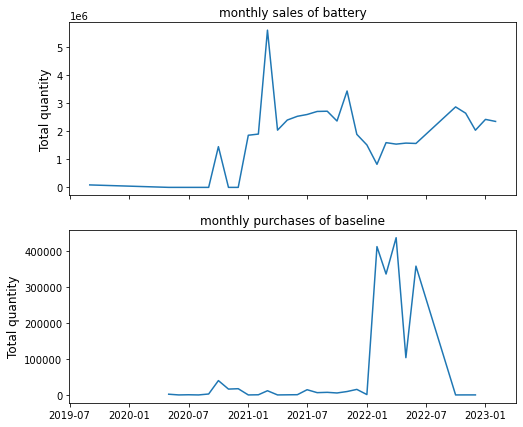

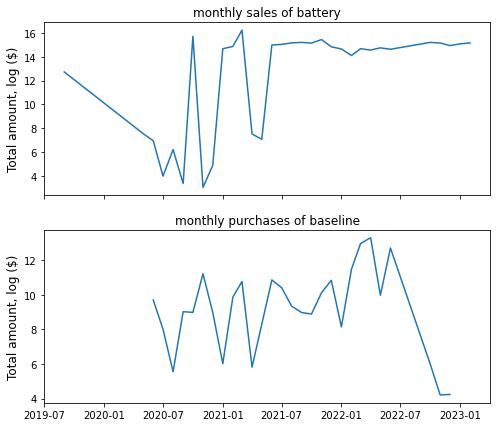

853710 325 r=-0.100 (n=27, p=0.619)
830242 36
630790 64
848120 118 r=0.279 (n=19, p=0.248)
490199 0


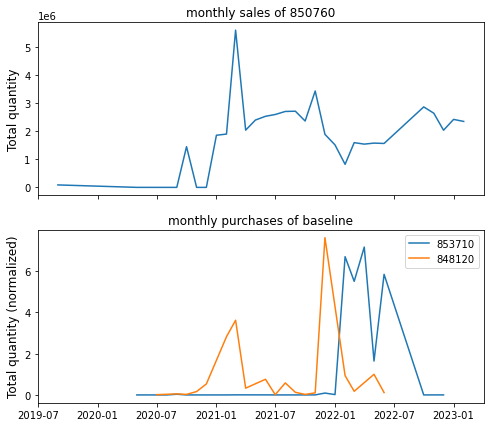

Supply name is battery; buy name is baseline
battery luxshare
53580 481667


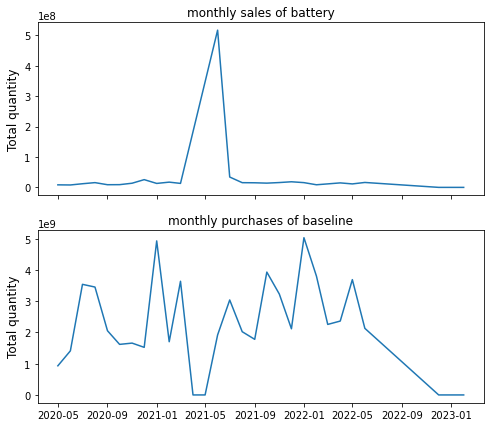

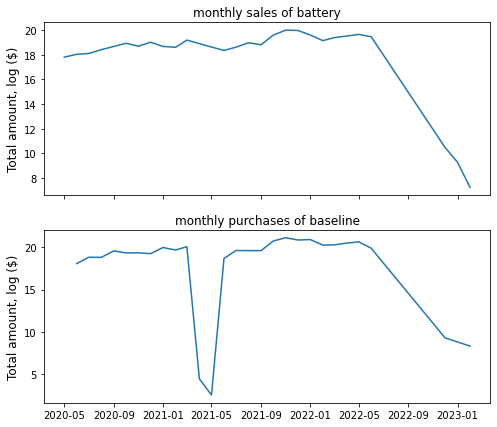

853710 1187 r=0.329 (n=25, p=0.109)
830242 0
630790 103 r=-0.514 (n=9, p=0.157)
848120 52
490199 0


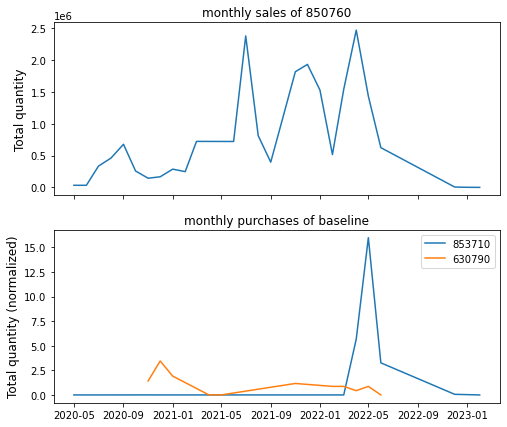

Supply name is battery; buy name is baseline
battery apple
887 56


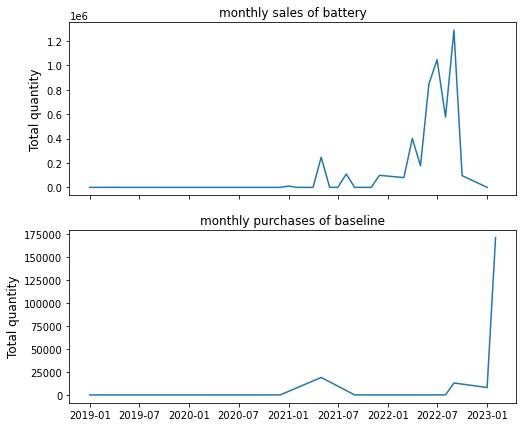

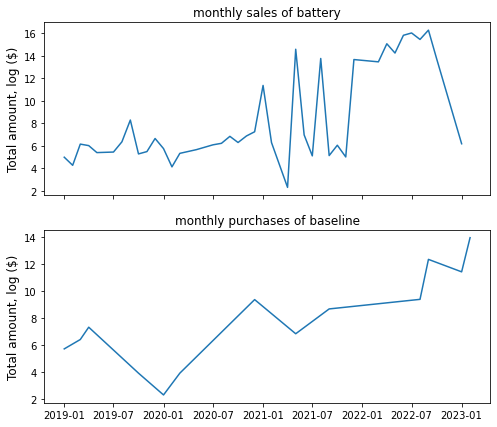

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


853710 32
830242 0
630790 13
848120 0
490199 11


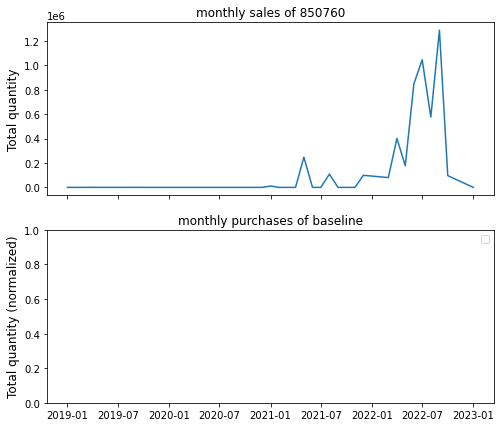

Supply name is battery; buy name is baseline
battery lg
119297 2402480


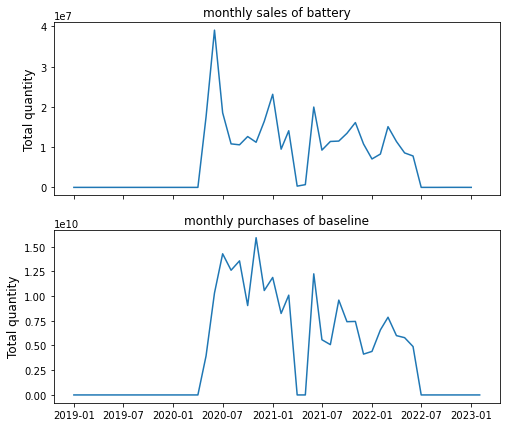

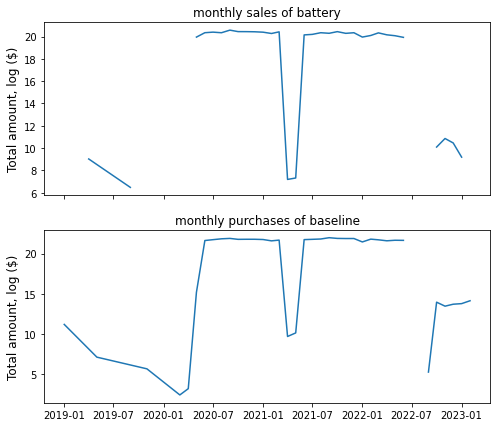

853710 24536 r=0.668 (n=35, p=0.000)
830242 15
630790 440 r=0.038 (n=22, p=0.865)
848120 100
490199 64


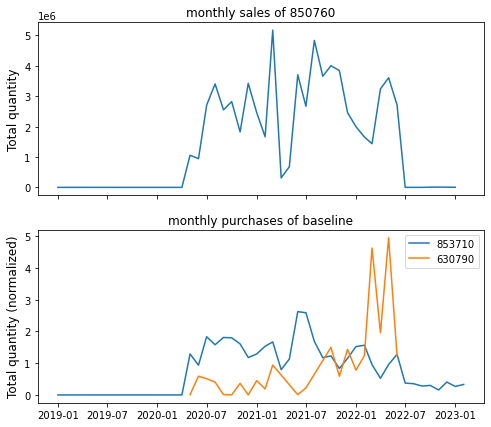

Supply name is battery; buy name is baseline
battery techtronic
55188 748595


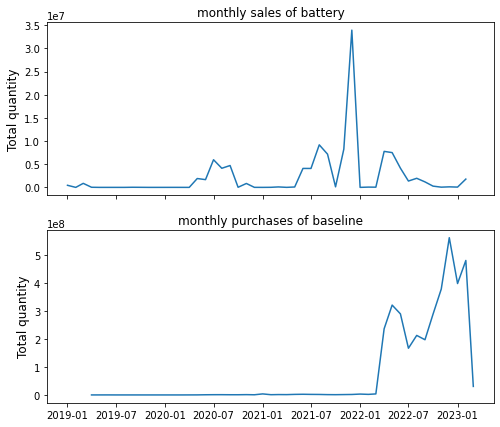

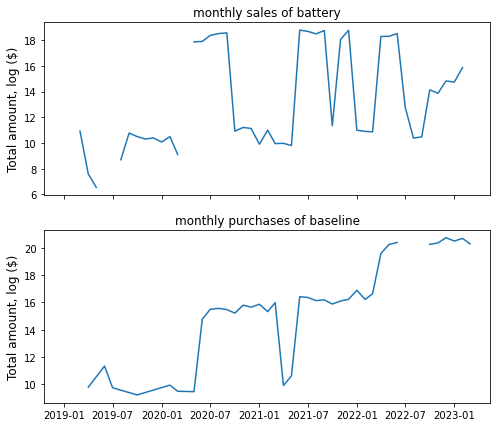

853710 42686 r=0.167 (n=20, p=0.482)
830242 0
630790 348 r=0.012 (n=10, p=0.973)
848120 0
490199 881 r=-0.237 (n=13, p=0.435)


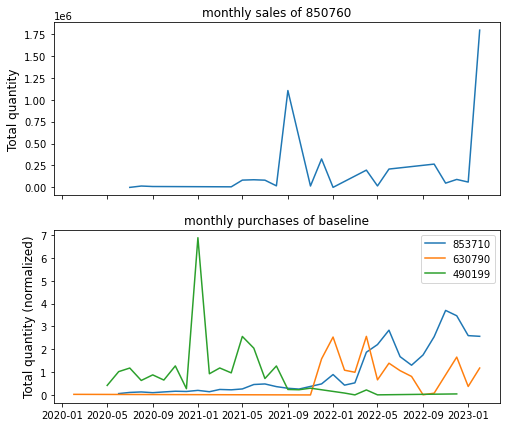

Supply name is battery; buy name is baseline
battery compal
244 345


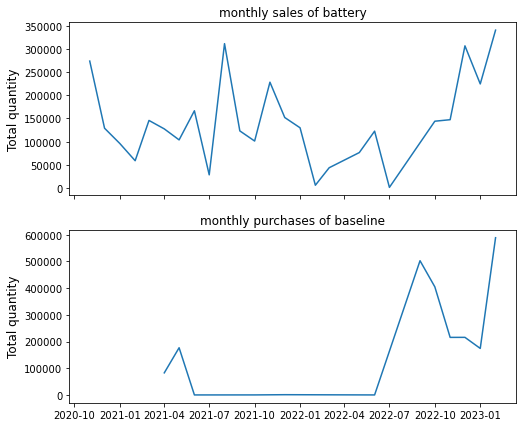

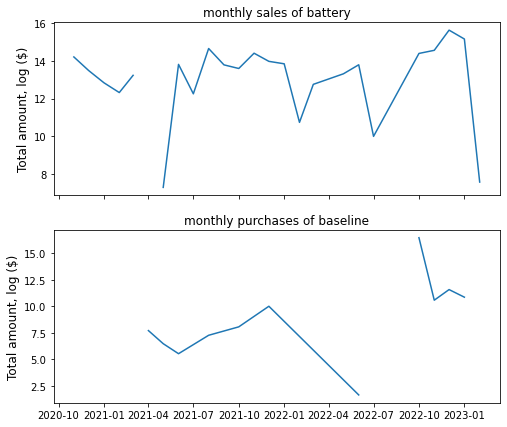

853710 68
830242 0
630790 24
848120 0
490199 253 r=0.748 (n=6, p=0.088)


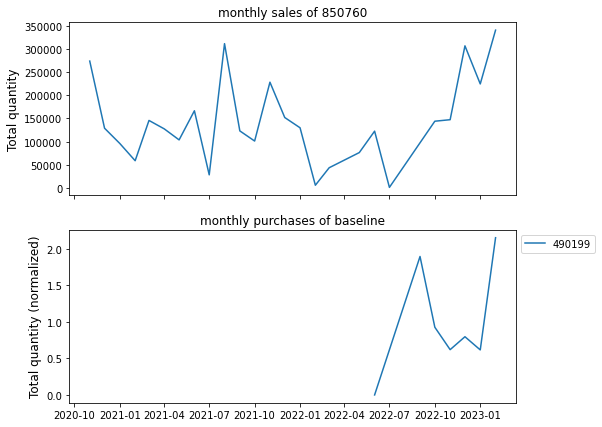

Supply name is battery; buy name is baseline
battery truper
228 2068


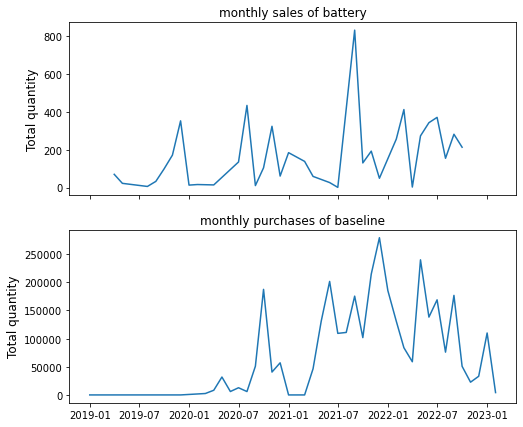

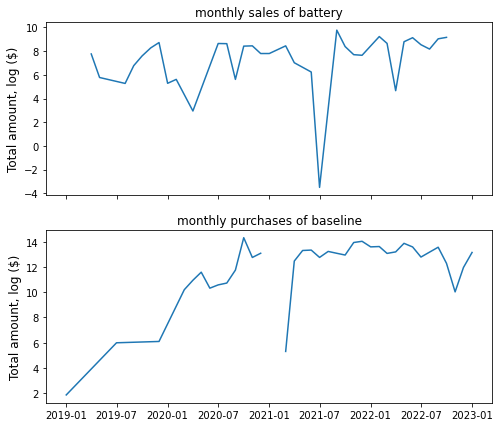

853710 69
830242 1179 r=0.180 (n=25, p=0.389)
630790 819 r=0.009 (n=26, p=0.965)
848120 1
490199 0


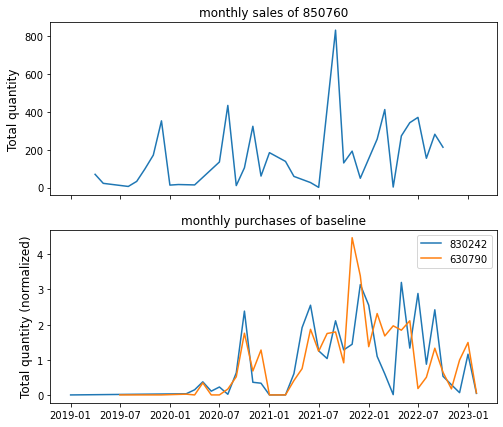

In [40]:
# 'verdant', 'wingtech', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 'tcl', 'hansol', 'buckeye',
# 'wistron'
companies = ['samsung', 'hp', 'elentec', 'itm', 'luxshare', 
             'apple', 'lg', 'techtronic', 'compal', 'truper']
SUPPLY_PROD='battery'
BUY_PROD=BASELINE_PROD

for csv_name in companies:
    supply_df, buy_df = get_transaction_time_df(SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, csv_name=csv_name)
    plot_time_versus_sale_purchase(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time='monthly', csv_name=csv_name)
    summary_df = compare_sale_purchase_quantity_per_hscode(supply_df, buy_df, SUPPLY_PROD=SUPPLY_PROD, BUY_PROD=BUY_PROD, time="monthly", csv_name=csv_name)
    summary_df = pd.DataFrame(summary_df, index=[0])

    summary_df.to_csv(f"./summary/{csv_name}_summary_baseline.csv", sep=',')
    del supply_df, buy_df
    
# TODO: concatenate and save summary_dfs

## Summary Table

In [42]:
# 'verdant', 'wingtech', 'arnold', 'hefei_gotion', 'shenzhen_chenshi', 'tcl', 'hansol', 'buckeye',
companies = ['samsung', 'hp', 'elentec', 'itm', 'luxshare', 
             'apple', 'lg', 'techtronic', 'compal', 'truper']
dfs = []
for company in companies: 
    df1 = pd.read_csv(f'./summary/{company}_summary.csv')
    df2 = pd.read_csv(f'./summary/{company}_summary_baseline.csv')
    
    df = pd.concat([df1, df2], axis=1)
    dfs.append(df)

In [43]:
df = pd.concat(dfs, axis=0) 
display(df)

,Unnamed: 0,group,# of supply txn battery_850760,# of buy txn bms_all,"corr battery_850760, bms_all monthly",# of supply txn bms_850450,"corr battery_850760, bms_850450 monthly",# of supply txn bms_850730,"corr battery_850760, bms_850730 monthly",# of supply txn bms_850780,...,# of supply txn baseline_853710,"corr battery_850760, baseline_853710 monthly",# of supply txn baseline_830242,"corr battery_850760, baseline_830242 monthly",# of supply txn baseline_630790,"corr battery_850760, baseline_630790 monthly",# of supply txn baseline_848120,"corr battery_850760, baseline_848120 monthly",# of supply txn baseline_490199,"corr battery_850760, baseline_490199 monthly"
0,0,samsung,47426,28444921,0.875323,608790,0.853383,17,NaN,918,...,58450,0.844662,367,0.244035,5860,0.707553,8482,0.724633,223163,0.830953
0,0,hp,4628,15547,0.001297,0,NaN,0,NaN,2,...,472,-0.058961,0,NaN,28,NaN,2,NaN,1,NaN
0,0,elentec,1996,1319,0.055127,63,NaN,0,NaN,0,...,34,NaN,0,NaN,0,NaN,0,NaN,1,NaN
0,0,itm,1513,17164,0.082692,16,NaN,0,NaN,3,...,325,-0.100213,36,NaN,64,NaN,118,0.278556,0,NaN
0,0,luxshare,505,1651492,0.441668,51828,0.259228,0,NaN,0,...,1187,0.328636,0,NaN,103,-0.513719,52,NaN,0,NaN
0,0,apple,887,4925,0.177007,9,NaN,0,NaN,0,...,32,NaN,0,NaN,13,NaN,0,NaN,11,NaN
0,0,lg,1260,8144148,0.699737,644878,0.233771,17,NaN,13,...,24536,0.667829,15,NaN,440,0.038421,100,NaN,64,NaN
0,0,techtronic,804,2526247,0.294583,35,NaN,0,NaN,0,...,42686,0.167035,0,NaN,348,0.012229,0,NaN,881,-0.237446
0,0,compal,244,9009,0.409465,2349,0.730144,0,NaN,0,...,68,NaN,0,NaN,24,NaN,0,NaN,253,0.747542
0,0,truper,228,1372,-0.070594,3,NaN,1,NaN,1,...,69,NaN,1179,0.180085,819,0.009016,1,NaN,0,NaN


# Demonstrate Database inconsistency

In [ ]:
tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df = rs.query_df(query)

tx_col = "buyer_t"
companies = ["globe exim"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from logistic_data where ({tx_string} and hs_code like '{hs}%');"
df2 = rs.query_df(query)

tx_col = "supplier_t"
companies = ["%neway %"]
hs = "850760"
tx_string = f"{tx_col} like '{companies[0]}'" + "".join([f" or {tx_col} like '{company}'" for company in companies[1:]])
query = f"select * from index_hs6 where ({tx_string} and hs6 like '{hs}%');"
df_1 = rs.query_df(query)